In [1]:
def _B(j, u, alphas, Nos, K):
    return (alphas[j] * Nos[j](u)) / sum((alphas[l] * Nos[l](u)) for l in range(K))


def _G(u, alphas, Nos, Cs, K):
    """
    denoise a single patch
    """
    return (
        sum(((alphas[j] * Nos[j](u)) * Cs[j]) for j in range(K))
        @ u
        / sum((alphas[l] * Nos[l](u)) for l in range(K))
    )


def _D(z, P, K, N, Pis, Cs, alphas, Nos):
    """
    gmm-denoise the signal
    """
    return 1 / P * sum(Pis[i].T @ _G(Pis[i] @ z, alphas, Nos, Cs, K) for i in range(N))

In [11]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_excel("data/PD data.xlsx")

In [5]:
train_signals = [
    np.array(df["s1sensor1"]),
    np.array(df["s1sensor2"]),
    np.array(df["s1sensor3"]),
    np.array(df["s1sensor4"]),
    np.array(df["s1sensor5"]),
]

In [6]:
test_signals = [
    np.array(df["s2sensor1"]),
    np.array(df["s2sensor2"]),
    np.array(df["s2sensor3"]),
    np.array(df["s2sensor4"]),
    np.array(df["s2sensor5"]),
]

In [10]:
from utils import calc_snr, snr_db_to_np, awgn

In [7]:
def make_Pi(i, P, N):
    """
    make_Pi(i, P, N) @ z extracts [z_i, z_i+1, ..., z_i+P-1] where len(z) = N
    """
    mat = np.zeros((P, N))
    for j in range(P):
        mat[j, (i + j) % N] = 1
    return mat


def get_patches(sig, P):
    """
    return list of all overlapping patches of length P each from sig
    """
    N = len(sig)
    patches = []
    for i in range(N):
        patches.append(make_Pi(i, P, N) @ sig)
    return patches

In [13]:
P = 30
K = 10
gmm = GaussianMixture(K)
gmm.fit(
    [
        patch
        for train_signal in train_signals
        for patch in get_patches(train_signal, P)
    ]
)

GaussianMixture(n_components=10)

In [103]:
nf = test_signals[0][:]
snr_db = -5
signal = awgn(nf, snr_db)
N = len(signal)

In [104]:
sigma2 = snr_db_to_np(signal, snr_db)
Pis = [make_Pi(i, P, N) for i in range(N)]
Cov1 = [
    gmm.covariances_[j] + sigma2 * np.eye(P) for j in range(K)
]
Cs = [gmm.covariances_[j] @ np.linalg.inv(Cov1[j]) for j in range(K)]
alphas = gmm.weights_
Nos = [
    multivariate_normal(mean=mu, cov=sigma).pdf
    for mu, sigma in zip(gmm.means_, Cov1)
]

In [105]:
lr = 2

9.251938385792949
9.383360284989678
9.365092531923816
9.773417070983644
9.557552163833115


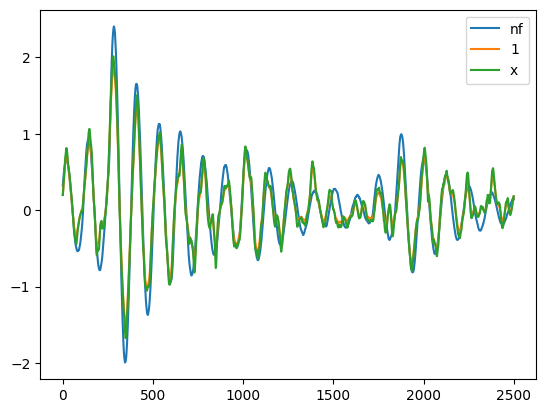

In [106]:
x0 = signal
x = x0
for i in range(5):
    x = _D(x - lr*(x - signal), P, K, N, Pis, Cs, alphas, Nos)
    print(calc_snr(nf, x))
    # plt.plot(x, label=f"x{i}")
plt.plot(nf, label="nf")
plt.plot(_D(signal, P, K, N, Pis, Cs, alphas, Nos), label="1")
plt.plot(x, label="x")
plt.legend()
